# Conditional Real-NVPs

**Goal:** Extend the Real-NVP model we built in `Real-NVP-tutorial` to make it conditional, i.e, a model for $p_\theta(x|y)$.

![](flow-graphic.png)



In [1]:
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

import math
import numpy as np
import torch
import torch.nn as nn

## First, some preliminaries copied over from the other nb

**Dataset**

In [2]:
nsamples = 30_000
noise = 0.05
X = make_moons(nsamples, noise=noise)[0]

X_torch = torch.Tensor(X).float()

**Hyperparameters and settings from the previous noteboook**

In [3]:
num_blocks=9
num_hidden=64

In [4]:
# Check for a GPU
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device='cpu'
    
print(device)

cuda:0


In [5]:
batch_size=256

nTrain=24_000
nVal=3_000

In [6]:
kwargs = {'num_workers': 4, 'pin_memory': True}  if torch.cuda.is_available() else {}

**Extended functionality to draw the model results with a conditional input**

In [7]:
def draw_model(model, cond_input=None, title=''):
    '''
    Goal: Given the given model weights, show
    (1) The density
    (2) Samples from p_X(x)
    
    Inputs:
    - model that we're plotting the density of
    - cond_input: Extra logic for the conditional gen model
                  (bonus prob)
    - title: Super title over 2 subfigs
    '''
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),
                                  gridspec_kw={'hspace':10})

    # Title the plot with the log(p) on the validation set
    if title:
        fig.suptitle(title)

    '''
    (1) Plot the density
    '''
    x = np.linspace(-1,2)
    y = np.linspace(-.75,1.25)

    xx,yy = np.meshgrid(x,y)

    X_grid = np.vstack([xx.flatten(),yy.flatten()]).T.astype(np.float32)
    X_grid.T

    X_grid = torch.tensor(X_grid).to(device)

    if cond_input:
        # For last (bonus) prob
        y0,y1 = cond_input
        Y_grid = torch.ones_like(X_grid).to(device)
        Y_grid[:,0] = y0
        Y_grid[:,1] = y1
    
        with torch.no_grad():
            log_probs = model.log_probs(X_grid,Y_grid).cpu().numpy()

    else:
        with torch.no_grad():
            log_probs = model.log_probs(X_grid).cpu().numpy()

    ax1.pcolormesh(xx,yy,np.exp(log_probs.reshape(50,50)),shading='auto',cmap='coolwarm')

    ax1.set_xlabel('$X_0$',fontsize=12)
    ax1.set_ylabel('$X_1$',fontsize=12)

    '''
    (2) Plot samples from the model
    '''
    with torch.no_grad():
        
        if cond_input:
            # For last (bonus) prob
            Y_con = torch.ones(500,2).to(device)
            Y_con[:,0] = y0
            Y_con[:,1] = y1
            X_gen = model.sample(Y_con).cpu().numpy()
        else:
            X_gen = model.sample(500).cpu().numpy()
        
    ax2.scatter(*X_gen.T)

    ax2.set_xlabel('$X_0$',fontsize=12)
    ax2.set_ylabel('$X_1$',fontsize=12)

    ax2.set_xlim(x[[0,-1]])
    ax2.set_ylim(y[[0,-1]])

    plt.show()


# Bonus: Conditional flow

Lots of applications in science involve conditional flow models, can you extend our the model we built here to be conditioned on the center point for the moon? 

**Plan:** 
- Train sampling moon density centers $y \in \mathbb{R}^2$ **uniformly** from [0,1]

Recall, we were training the 30k training samples for modelling 2 dimensions.

In [14]:
num_inputs = X.shape[1]

Y = torch.Tensor(nsamples, num_inputs).uniform_()

In [15]:
X_cond = X_torch + Y

**Let's look at the prediction for some slices of the conditional output**
- $0 < y_0, y_1 < .05$ 
- $0.5 < y_0, y_1 < .55$ 
- $0.95 < y_0, y_1 < 1$ 

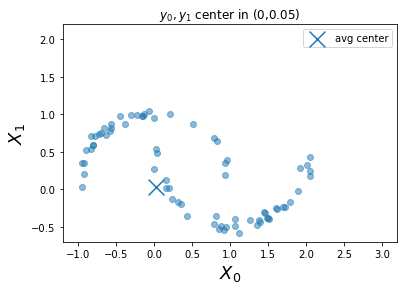

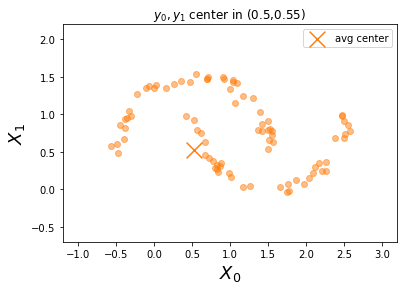

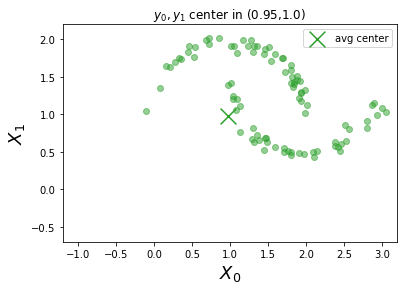

In [16]:
dy = .05
for i,y_min in enumerate([0,.5,1-dy]):
    
    y_max = y_min+dy
    mi = (Y[:,0] > y_min) & (Y[:,0] < y_max)
    mi = mi & (Y[:,1] > y_min) & (Y[:,1] < y_max)
    
    y_avg = .5 * (y_min + y_max)
    
    c=f'C{i}'
    plt.scatter(*X_cond[mi].T.numpy(),alpha=.5,color=c)
    plt.scatter([y_avg],[y_avg],250,marker='x',label='avg center',color=c)
    plt.xlabel('$X_0$',fontsize=18)
    plt.ylabel('$X_1$',fontsize=18)
    plt.legend()
    plt.title(f'$y_0,y_1$ center in ({y_min},{y_max})')
    
    plt.xlim(-1.2,3.2)
    plt.ylim(-.7,2.2)
    plt.show()
    

### TO DO: Implement the conditional flow model

**Hint 1:** Extend the coupling layer to a conditional coupling layer

In [17]:
class CondCouplingLayer(nn.Module):
    """ An implementation of a coupling layer
    from RealNVP (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, num_cond_inputs, num_hidden, mask):
        super(CondCouplingLayer, self).__init__()

        self.num_inputs = num_inputs
        self.num_cond_inputs = num_cond_inputs
        self.mask = mask
        
        num_all_inputs = num_inputs + num_cond_inputs
            
        self.log_s_net = nn.Sequential(
            nn.Linear(num_all_inputs, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_inputs))
        
        self.t_net = nn.Sequential(
            nn.Linear(num_all_inputs, num_hidden), nn.ReLU(),
            nn.Linear(num_hidden, num_hidden), nn.ReLU(),
            nn.Linear(num_hidden, num_inputs))

    def forward(self, inputs, cond_inputs,  mode='forward'):
        '''
        Returns a tuple with 
        - the transofrmation, f(inpts)
        - and the log Jacobian of f

        Whether we apply f or f^{-1} depends on whether we're running 
        with `mode` as forward or reverse
        '''
        mask = self.mask
        masked_inputs = inputs * mask
        
        all_inputs = torch.cat([masked_inputs, cond_inputs],axis=1)
        
        if mode == 'forward':
            
            log_s = self.log_s_net(all_inputs) * (1 - mask)
            t = self.t_net(all_inputs) * (1 - mask)
            s = torch.exp(log_s)
            
            out = inputs * s + t
            
            return out, log_s.sum(-1, keepdim=True)
                        
        else:
            
            log_s = self.log_s_net(all_inputs) * (1 - mask)
            t = self.t_net(all_inputs) * (1 - mask)
            s = torch.exp(log_s)

            log_jacob = -log_s.sum(-1, keepdim=True)
            
            return (inputs - t) / s, log_jacob

**Hint 2:** Implement a `CondFlowSequential` class that calls the `CondCouplingLayer` class.

In [18]:
class CondFlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def forward(self, inputs, cond_inputs, mode='forward'):
        """ Performs a forward or reverse pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        
        self.num_inputs = inputs.size(-1)

        logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['forward', 'reverse']
        if mode == 'forward':
            for module in self._modules.values():
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs, cond_inputs):
        u, log_jacob = self(inputs, cond_inputs,mode='reverse')
          
        log_probs = (-0.5 * u.pow(2) - 0.5 * math.log(2 * math.pi)).sum(-1, keepdim=True)
        return (log_probs + log_jacob).sum(-1, keepdim=True)

    def sample(self, cond_inputs, num_samples=None):
        
        if num_samples is None:
            num_samples = cond_inputs.shape[0]
        
        assert cond_inputs.shape[0] == num_samples
        
        noise = torch.Tensor(num_samples, self.num_inputs).normal_()
        noise = noise.to(device)

        samples = self.forward(noise, cond_inputs, mode='forward')[0]
        
        return samples

**Put the pieces together to define a flow**

In [22]:
# Extending the code that we had before
num_cond_inputs = Y.shape[1]

mask = torch.arange(0, num_inputs) % 2
mask = mask.to(device).float()

modules=[]
for _ in range(num_blocks):
    modules.append( CondCouplingLayer( num_inputs, num_cond_inputs, num_hidden, mask) )
    mask = 1 - mask

In [23]:
# To DO: Define the conditional flow from these modules
cond_flow = CondFlowSequential(*modules)

In [24]:
cond_flow = cond_flow.to(device)

**Training code**

It's the same as before, just evaluating the conditional generative model, so we'll just give you the training functions.

We'll just use a `from torch.utils.data.Dataset` first to pass to the `DataLoaders` that we'll create :)

In [25]:
'''
New dataset class to deal w/ the tuple of X,Y input
'''

from torch.utils.data import Dataset

class CondMoonsDataset(Dataset):
    '''
    Skeleton class taken from:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    '''
    def __init__(self,nExamples,noise=0.05):
        
        X_np = make_moons(nExamples, noise=noise)[0]
        X = torch.Tensor(X_np).float()
            
        num_inputs = X.shape[1]
        Y = torch.Tensor(nExamples, num_inputs).uniform_()
         
        X = X+Y
            
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [26]:
cond_train_loader = torch.utils.data.DataLoader(
    CondMoonsDataset(nTrain), 
    batch_size=batch_size, shuffle=True,**kwargs)

cond_valid_loader = torch.utils.data.DataLoader(
    CondMoonsDataset(nVal),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    CondMoonsDataset(nVal),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

In [27]:
def cond_train(model, train_loader, opt):
    
    model.train()
    train_loss = 0

    for batch_idx, (X,Y) in enumerate(train_loader):
        
        X = X.to(device) 
        Y = Y.to(device) 
        opt.zero_grad()
        
        loss = -model.log_probs(X,Y).mean()
        train_loss += loss.item()
        
        loss.backward()
        opt.step()
        
    train_loss /= len(train_loader)
    return train_loss

def cond_validate(model, loader, prefix='Validation'):
    
    model.eval()
    val_loss = 0

    for batch_idx, (X,Y) in enumerate(loader):

        X = X.to(device) 
        Y = Y.to(device) 
            
        with torch.no_grad():
            val_loss += -model.log_probs(X,Y).sum().item()  # sum up batch loss
     
    val_loss /= len(loader.dataset)
    return val_loss 

Epoch 0: train loss = 2.4363, val loss = 2.0286


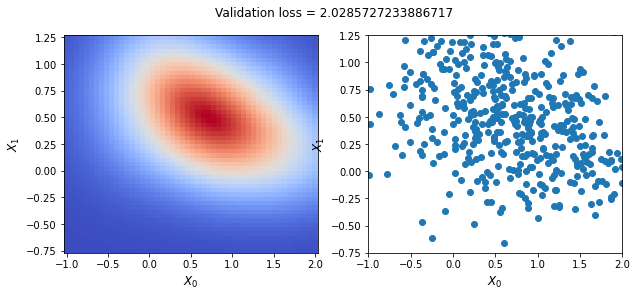

Epoch 1: train loss = 1.9265, val loss = 1.8618
Epoch 2: train loss = 1.8017, val loss = 1.7547
Epoch 3: train loss = 1.6966, val loss = 1.6427
Epoch 4: train loss = 1.5703, val loss = 1.4838
Epoch 5: train loss = 1.3860, val loss = 1.2972
Epoch 6: train loss = 1.2177, val loss = 1.1668
Epoch 7: train loss = 1.1134, val loss = 1.0670
Epoch 8: train loss = 1.0596, val loss = 1.0166
Epoch 9: train loss = 1.0044, val loss = 0.9668
Epoch 10: train loss = 0.9535, val loss = 0.9353


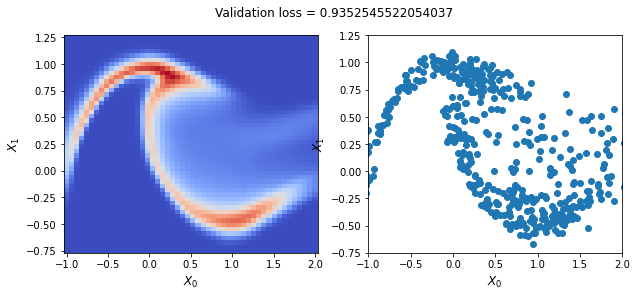

Epoch 11: train loss = 0.9107, val loss = 0.9155
Epoch 12: train loss = 0.8778, val loss = 0.8474
Epoch 13: train loss = 0.8432, val loss = 0.8211
Epoch 14: train loss = 0.8175, val loss = 0.7885
Epoch 15: train loss = 0.7929, val loss = 0.7635
Epoch 16: train loss = 0.7664, val loss = 0.7369
Epoch 17: train loss = 0.7488, val loss = 0.7256
Epoch 18: train loss = 0.7332, val loss = 0.7071
Epoch 19: train loss = 0.7109, val loss = 0.6953
Epoch 20: train loss = 0.7102, val loss = 0.7252


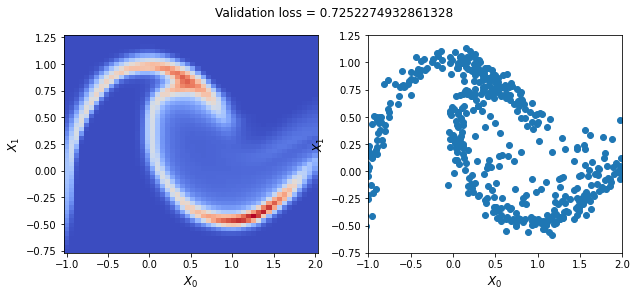

Epoch 21: train loss = 0.6942, val loss = 0.7131
Epoch 22: train loss = 0.6652, val loss = 0.6390
Epoch 23: train loss = 0.6505, val loss = 0.6493
Epoch 24: train loss = 0.6572, val loss = 0.6265
Epoch 25: train loss = 0.6329, val loss = 0.6194
Epoch 26: train loss = 0.6185, val loss = 0.5985
Epoch 27: train loss = 0.6119, val loss = 0.5896
Epoch 28: train loss = 0.6002, val loss = 0.5865
Epoch 29: train loss = 0.5916, val loss = 0.5748
Epoch 30: train loss = 0.5783, val loss = 0.5661


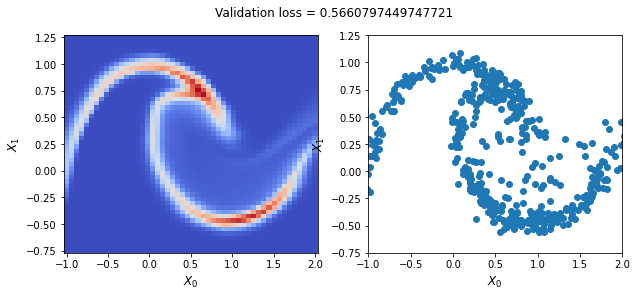

Epoch 31: train loss = 0.5765, val loss = 0.5643
Epoch 32: train loss = 0.5610, val loss = 0.5505
Epoch 33: train loss = 0.5627, val loss = 0.5419
Epoch 34: train loss = 0.5353, val loss = 0.5276
Epoch 35: train loss = 0.5294, val loss = 0.5151
Epoch 36: train loss = 0.5203, val loss = 0.5301
Epoch 37: train loss = 0.5031, val loss = 0.5059
Epoch 38: train loss = 0.4933, val loss = 0.4998
Epoch 39: train loss = 0.4932, val loss = 0.4989
Epoch 40: train loss = 0.4832, val loss = 0.4763


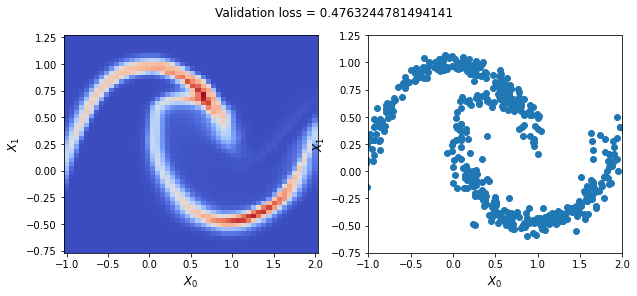

Epoch 41: train loss = 0.4785, val loss = 0.4883
Epoch 42: train loss = 0.4649, val loss = 0.4880
Epoch 43: train loss = 0.4617, val loss = 0.4787
Epoch 44: train loss = 0.4609, val loss = 0.4735
Epoch 45: train loss = 0.4509, val loss = 0.4555
Epoch 46: train loss = 0.4549, val loss = 0.4596
Epoch 47: train loss = 0.4492, val loss = 0.4540
Epoch 48: train loss = 0.4376, val loss = 0.4471
Epoch 49: train loss = 0.4389, val loss = 0.4884
Epoch 50: train loss = 0.4318, val loss = 0.4381


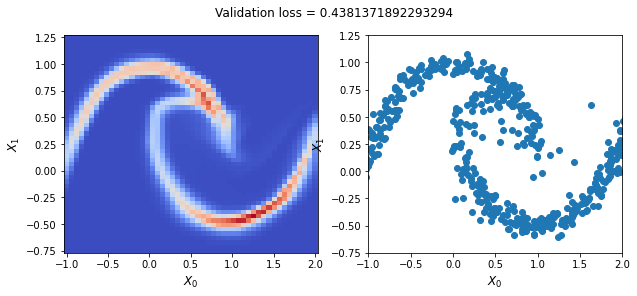

Epoch 51: train loss = 0.4320, val loss = 0.4701
Epoch 52: train loss = 0.4320, val loss = 0.5205
Epoch 53: train loss = 0.4287, val loss = 0.4242
Epoch 54: train loss = 0.4206, val loss = 0.4300
Epoch 55: train loss = 0.4300, val loss = 0.4271
Epoch 56: train loss = 0.4178, val loss = 0.4379
Epoch 57: train loss = 0.4172, val loss = 0.4161
Epoch 58: train loss = 0.4118, val loss = 0.4253
Epoch 59: train loss = 0.4076, val loss = 0.4382
Epoch 60: train loss = 0.4037, val loss = 0.4213


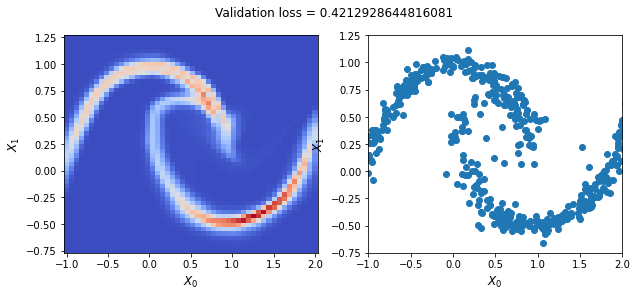

Epoch 61: train loss = 0.4038, val loss = 0.4311
Epoch 62: train loss = 0.4063, val loss = 0.4287
Epoch 63: train loss = 0.4014, val loss = 0.4171
Epoch 64: train loss = 0.4025, val loss = 0.4223
Epoch 65: train loss = 0.4003, val loss = 0.4167
Epoch 66: train loss = 0.3983, val loss = 0.4120
Epoch 67: train loss = 0.3954, val loss = 0.4111
Epoch 68: train loss = 0.3947, val loss = 0.4202
Epoch 69: train loss = 0.4029, val loss = 0.4139
Epoch 70: train loss = 0.3962, val loss = 0.4274


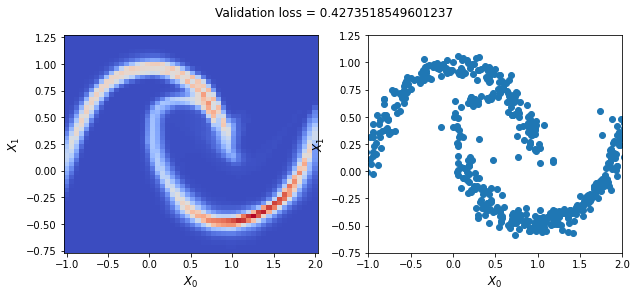

Epoch 71: train loss = 0.3945, val loss = 0.4086
Epoch 72: train loss = 0.3871, val loss = 0.4045
Epoch 73: train loss = 0.3897, val loss = 0.3991
Epoch 74: train loss = 0.3910, val loss = 0.4081
Epoch 75: train loss = 0.3850, val loss = 0.4014
Epoch 76: train loss = 0.3829, val loss = 0.3919
Epoch 77: train loss = 0.3829, val loss = 0.3935
Epoch 78: train loss = 0.3822, val loss = 0.3920
Epoch 79: train loss = 0.3827, val loss = 0.3942
Epoch 80: train loss = 0.3796, val loss = 0.4074


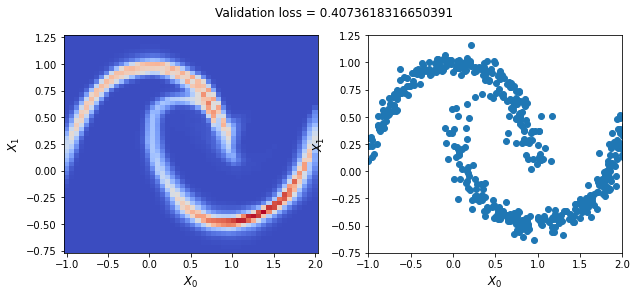

In [28]:
lr=1e-4
opt = torch.optim.Adam(cond_flow.parameters(), lr=lr, weight_decay=1e-6)

epochs=81

cond_train_losses = np.zeros(epochs)
cond_val_losses = np.zeros(epochs)

for i in range(epochs):
    
    cond_train_losses[i] = cond_train(cond_flow, cond_train_loader, opt)
    cond_val_losses[i] = cond_validate(cond_flow, cond_valid_loader)

    print(f'Epoch {i}: train loss = {cond_train_losses[i]:.4f}, val loss = {cond_val_losses[i]:.4f}')
        
    if i % 10 == 0:
        # Draw the model prediction
        draw_model(cond_flow,cond_input=[0,0],
                   title=f'Validation loss = {cond_val_losses[i]}')
        

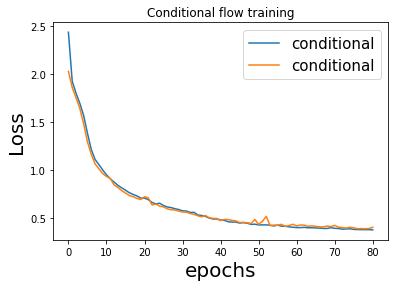

In [29]:
plt.plot(cond_train_losses,label='conditional')
plt.plot(cond_val_losses,label='conditional')

plt.xlabel('epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=15)
plt.title('Conditional flow training')
plt.show()

**Sanity check:** What have we learned about crescent moons in the three cases that we had above?

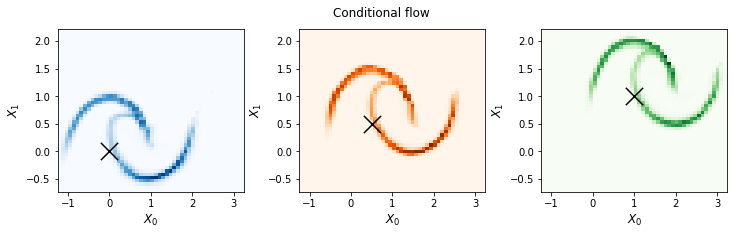

In [30]:
fig, axs = plt.subplots(1,3,figsize=(12,3),
                            gridspec_kw={'wspace':.3})

fig.suptitle('Conditional flow')

# Define the density grid
x = np.linspace(-1.2,3.2)
y = np.linspace(-.7,2.2)

xx,yy = np.meshgrid(x,y)

X_grid = np.vstack([xx.flatten(),yy.flatten()]).T.astype(np.float32)
X_grid.T

X_grid = torch.tensor(X_grid).to(device)

'''
Loop over the centers
'''
for yi,ax,cmap in zip([0, 0.5, 1],axs,['Blues','Oranges','Greens']):
    
    # Plot the density
    
    Y_grid = torch.ones_like(X_grid).to(device)
    Y_grid[:,0] *= yi
    Y_grid[:,1] *= yi
    
    with torch.no_grad():
        log_probs = cond_flow.log_probs(X_grid,Y_grid).cpu().numpy()

    ax.pcolormesh(xx,yy,np.exp(log_probs.reshape(50,50)),shading='auto',cmap=cmap)

    ax.set_xlabel('$X_0$',fontsize=12)
    ax.set_ylabel('$X_1$',fontsize=12)

    ax.scatter([yi],[yi],300,marker='x',color='k')
    # break
plt.show()


Yep, we learned about a conditional density that varies in the training box :)

**Resources:**
- This tutorial for the code in this repo came from the [pytorch-flows](https://github.com/ikostrikov/pytorch-flows) repo.
- The [nflows](https://github.com/bayesiains/nflows.git) is also a very nice package that includes the Real-NVP model and also the RQ-NSF that we also talked about in the lecture.